In [128]:
import pandas as pd
import numpy as np
import requests
import re
import smopy
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("../dataset/apartamentos.csv")
df = df[df['precio'].str.contains('mes')]
df['precio'] = df['precio'].apply(lambda x: re.sub(r' €/mes|\.', '', x)).astype(int)
df['zona'] = df['zona'].apply(lambda x: re.sub(r'Alquilar en | \([^)]*\)', '', x))
df['detalles'] = df['detalles'].apply(lambda x: re.sub(r'\[|\]|\'', '', x))
df['detalles'] = df['detalles'].apply(lambda x: x.split(','))
df[['n_habitaciones', 'n_baños', 'm_cuadrados', 'planta']] = df['detalles'].apply(lambda x: pd.Series(x if len(x) == 4 else x + [None] * (4 - len(x))))
df = df[df['zona'] != 'Cerdanya Francesa']
df

,titulo,url,zona,dirección,precio,detalles,descripcion,fecha extraccion,n_habitaciones,n_baños,m_cuadrados,planta
1,Piso en Aguadulce Norte,https://www.pisos.com/alquilar/piso-aguadulce_...,Almería,Aguadulce Norte (Distrito Aguadulce. Roquetas ...,800,"[3 habs., 2 baños, 100 m², 6ª planta]","Piso con muebles. Altura piso , piso superfici...",2023-04-25 11:42:58,3 habs.,2 baños,100 m²,6ª planta
2,Piso en Aguadulce Sur,https://www.pisos.com/alquilar/piso-aguadulce_...,Almería,Aguadulce Sur (Distrito Aguadulce. Roquetas de...,750,"[2 habs., 1 baño, 87 m², 3ª planta]","Piso con muebles. Altura piso 3º, piso superfi...",2023-04-25 11:42:58,2 habs.,1 baño,87 m²,3ª planta
3,"Piso en calle Azorín, 26",https://www.pisos.com/alquilar/piso-oliveros_a...,Almería,Oliveros-Altamira-Barrio Alto (Almería Capital),650,"[2 habs., 2 baños, 80 m², 7ª planta]",Piso en centro de la ciudad de almería frente ...,2023-04-25 11:42:58,2 habs.,2 baños,80 m²,7ª planta
4,Piso en calle del Galeón,https://www.pisos.com/alquilar/piso-el_ejido_a...,Almería,Almerimar (El Ejido),700,"[3 habs., 2 baños, 140 m²]",Amplio y luminoso apartamento en alquiler en a...,2023-04-25 11:42:58,3 habs.,2 baños,140 m²,None
6,Piso en calle de El Greco,https://www.pisos.com/alquilar/piso-barrio_de_...,Almería,Barrio de Archilla (Vícar),650,"[4 habs., 1 baño, 200 m², 1ª planta]",Alquilamos este gran piso en la localidad de v...,2023-04-25 11:42:58,4 habs.,1 baño,200 m²,1ª planta
...,...,...,...,...,...,...,...,...,...,...,...,...
18844,"Apartamento en calle Jardín del Mar, nº 5",https://www.pisos.com/alquilar/apartamento-km_...,Murcia,Km 6-Km 8 (La Manga del Mar Menor),1000,"[1 hab., 1 baño, 9ª planta]",Apartamento tipo loft amueblado km 7 de la man...,2023-04-25 13:47:30,1 hab.,1 baño,9ª planta,None
18845,"Piso en calle Isla Cunillera, 6",https://www.pisos.com/alquilar/piso-los_nietos...,Murcia,Islas Menores-Mar de Cristal (Distrito Mar Men...,1800,"[3 habs., 1 baño, 1ª planta]","Apartamento, muy próximo a la playa, en urbani...",2023-04-25 13:47:30,3 habs.,1 baño,1ª planta,None
18850,"Apartamento en calle Collados Zieschang, 57",https://www.pisos.com/alquilar/apartamento-agu...,Murcia,Los Geráneos (Águilas),400,"[2 habs., 1 baño, 1ª planta]",Apartamento turístico a menos de 5 minutos de ...,2023-04-25 13:47:31,2 habs.,1 baño,1ª planta,None
18851,"Piso en calle de Pizarro, 7",https://www.pisos.com/alquilar/piso-calarreona...,Murcia,Calarreona-Las Lomas (Águilas),500,"[2 habs., 1 baño, 1ª planta]",Se alquila piso en águilas urbanización la tor...,2023-04-25 13:47:31,2 habs.,1 baño,1ª planta,None


In [34]:

respuesta = requests.get('https://nominatim.openstreetmap.org/search?format=json&limit=1&q=Porta, España')
respuesta.json()[0]

{'place_id': 308765650,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 4143082,
 'boundingbox': ['41.4301967', '41.4396195', '2.1720452', '2.1852655'],
 'lat': '41.4331882',
 'lon': '2.1760336',
 'display_name': 'Porta, Nou Barris, Barcelona, Barcelonès, Barcelona, Catalunya, 08001, España',
 'class': 'boundary',
 'type': 'administrative',
 'importance': 0.5891140618721555,
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}

In [3]:
def get_cordinadas(row, endpoint_url = 'https://nominatim.openstreetmap.org/search?format=json&limit=1&q=',
                   pais='España'):
    direccion = row['dirección']
    zona = row['zona']
    try:
        respuesta = requests.get(f'{endpoint_url}{direccion} {zona}, {pais}')
        if respuesta.status_code == 200:
            return respuesta.json()[0].get("lat"), respuesta.json()[0].get("lon")
    except:
        pass
    return None, None
                             

In [4]:
df['coordenadas'] = df.apply(get_cordinadas, axis=1)
df

,titulo,url,zona,dirección,precio,detalles,descripcion,fecha extraccion,n_habitaciones,n_baños,m_cuadrados,planta,coordenadas
1,Piso en Aguadulce Norte,https://www.pisos.com/alquilar/piso-aguadulce_...,Almería,Aguadulce Norte (Distrito Aguadulce. Roquetas ...,800,"[3 habs., 2 baños, 100 m², 6ª planta]","Piso con muebles. Altura piso , piso superfici...",2023-04-25 11:42:58,3 habs.,2 baños,100 m²,6ª planta,"(None, None)"
2,Piso en Aguadulce Sur,https://www.pisos.com/alquilar/piso-aguadulce_...,Almería,Aguadulce Sur (Distrito Aguadulce. Roquetas de...,750,"[2 habs., 1 baño, 87 m², 3ª planta]","Piso con muebles. Altura piso 3º, piso superfi...",2023-04-25 11:42:58,2 habs.,1 baño,87 m²,3ª planta,"(None, None)"
3,"Piso en calle Azorín, 26",https://www.pisos.com/alquilar/piso-oliveros_a...,Almería,Oliveros-Altamira-Barrio Alto (Almería Capital),650,"[2 habs., 2 baños, 80 m², 7ª planta]",Piso en centro de la ciudad de almería frente ...,2023-04-25 11:42:58,2 habs.,2 baños,80 m²,7ª planta,"(None, None)"
4,Piso en calle del Galeón,https://www.pisos.com/alquilar/piso-el_ejido_a...,Almería,Almerimar (El Ejido),700,"[3 habs., 2 baños, 140 m²]",Amplio y luminoso apartamento en alquiler en a...,2023-04-25 11:42:58,3 habs.,2 baños,140 m²,None,"(36.707867, -2.8074558)"
6,Piso en calle de El Greco,https://www.pisos.com/alquilar/piso-barrio_de_...,Almería,Barrio de Archilla (Vícar),650,"[4 habs., 1 baño, 200 m², 1ª planta]",Alquilamos este gran piso en la localidad de v...,2023-04-25 11:42:58,4 habs.,1 baño,200 m²,1ª planta,"(36.7976539, -2.6091448)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18844,"Apartamento en calle Jardín del Mar, nº 5",https://www.pisos.com/alquilar/apartamento-km_...,Murcia,Km 6-Km 8 (La Manga del Mar Menor),1000,"[1 hab., 1 baño, 9ª planta]",Apartamento tipo loft amueblado km 7 de la man...,2023-04-25 13:47:30,1 hab.,1 baño,9ª planta,None,"(None, None)"
18845,"Piso en calle Isla Cunillera, 6",https://www.pisos.com/alquilar/piso-los_nietos...,Murcia,Islas Menores-Mar de Cristal (Distrito Mar Men...,1800,"[3 habs., 1 baño, 1ª planta]","Apartamento, muy próximo a la playa, en urbani...",2023-04-25 13:47:30,3 habs.,1 baño,1ª planta,None,"(None, None)"
18850,"Apartamento en calle Collados Zieschang, 57",https://www.pisos.com/alquilar/apartamento-agu...,Murcia,Los Geráneos (Águilas),400,"[2 habs., 1 baño, 1ª planta]",Apartamento turístico a menos de 5 minutos de ...,2023-04-25 13:47:31,2 habs.,1 baño,1ª planta,None,"(37.4239333, -1.5482341)"
18851,"Piso en calle de Pizarro, 7",https://www.pisos.com/alquilar/piso-calarreona...,Murcia,Calarreona-Las Lomas (Águilas),500,"[2 habs., 1 baño, 1ª planta]",Se alquila piso en águilas urbanización la tor...,2023-04-25 13:47:31,2 habs.,1 baño,1ª planta,None,"(None, None)"


In [5]:
df.to_csv('../dataset/apartamentos_clean.csv')

Lowered zoom level to keep map size reasonable. (z = 6)


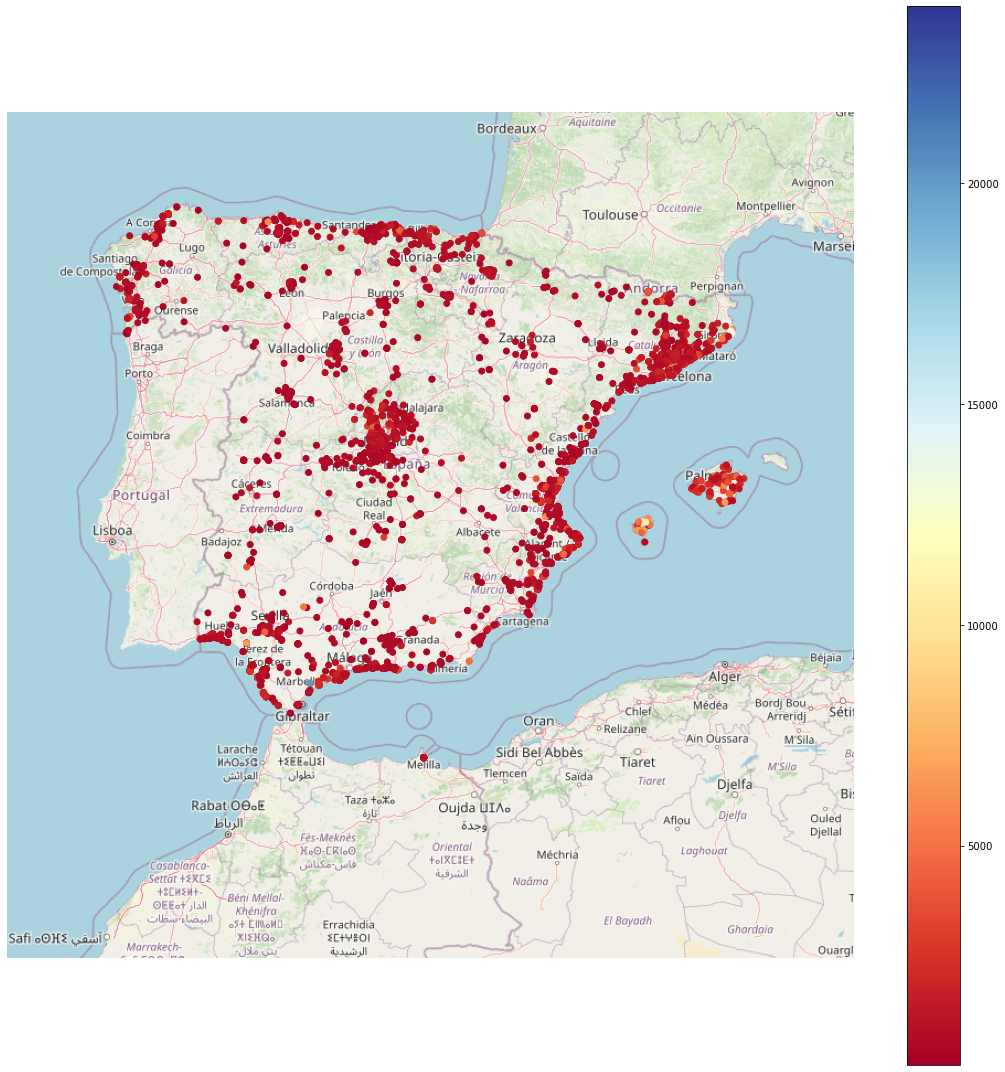

In [61]:
smopy_map = smopy.Map(43.819624, -10.609599,35.643584, 1.789158)


# Aplicamos la transformación a los pixeles del mapa
map_pixels = lambda x : smopy_map.to_pixels(x)
coordinadas = df[df['coordenadas']!=(None,None)]
map_medians=list(map(map_pixels,coordinadas['coordenadas'].apply(lambda x: [float(i) for i in x])))

ax = smopy_map.show_mpl(figsize=(15, 15))

scatter = ax.scatter([x[0] for x in map_medians],[x[1] for x in map_medians],c=coordinadas['precio'],cmap='RdYlBu');
plt.colorbar(scatter)

In [62]:
# Calcular la media y la desviación estándar de la columna
media = df['precio'].mean()
desviacion = df['precio'].std()

# Definir los umbrales para los valores atípicos
umbral_superior = media + 1 * desviacion
umbral_inferior = media - 1 * desviacion

# Filtrar los valores atípicos
df_filtrado = df[(df['precio'] <= umbral_superior) & (df['precio'] >= umbral_inferior)]


Lowered zoom level to keep map size reasonable. (z = 6)


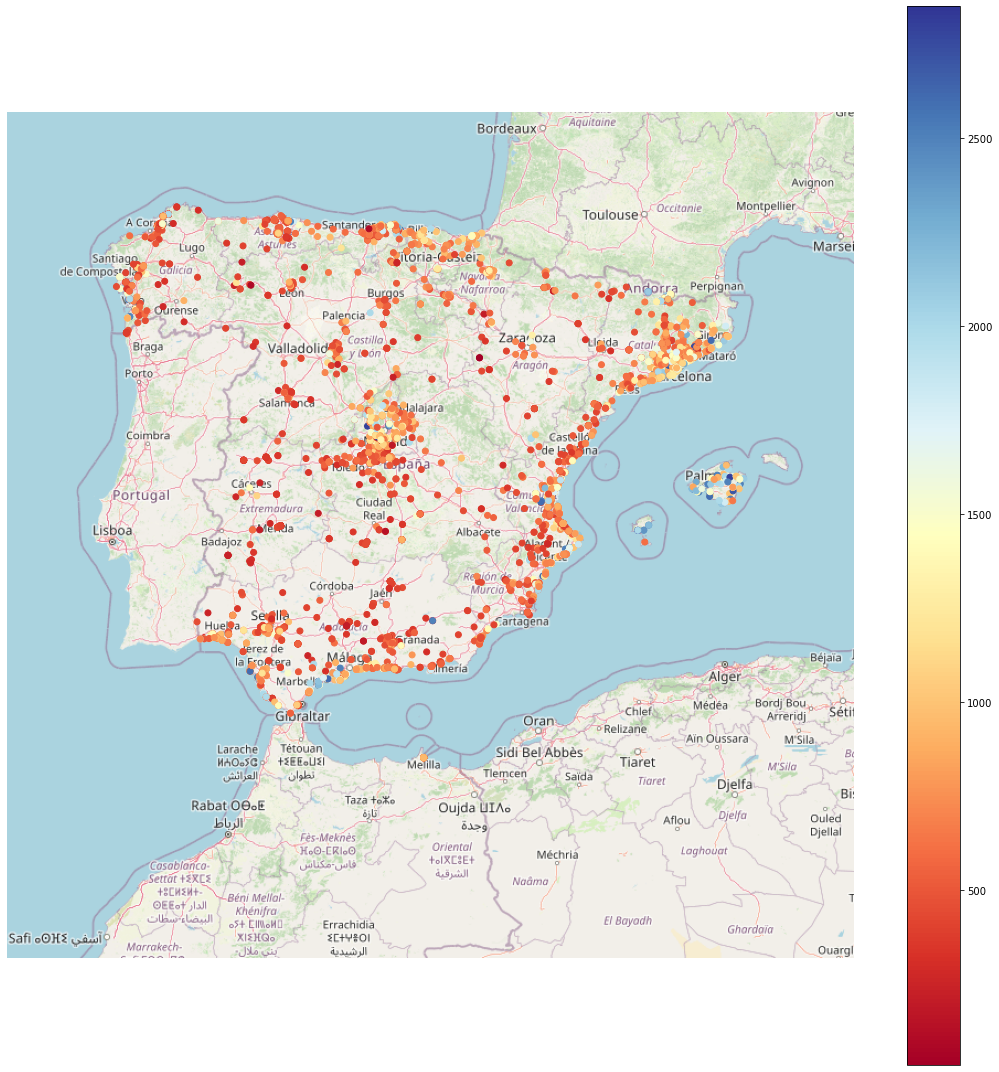

In [63]:
smopy_map = smopy.Map(43.819624, -10.609599,35.643584, 1.789158)


# Aplicamos la transformación a los pixeles del mapa
map_pixels = lambda x : smopy_map.to_pixels(x)
coordinadas = df_filtrado[df_filtrado['coordenadas']!=(None,None)]
map_medians=list(map(map_pixels,coordinadas['coordenadas'].apply(lambda x: [float(i) for i in x])))

ax = smopy_map.show_mpl(figsize=(15, 15))

scatter = ax.scatter([x[0] for x in map_medians],[x[1] for x in map_medians],c=coordinadas['precio'],cmap='RdYlBu');
plt.colorbar(scatter)

## 4. Análisis de los datos.

In [122]:
df[['m_cuadrados','n_habitaciones', 'n_baños']] = df[['m_cuadrados','n_habitaciones', 'n_baños']].astype(str)
df_clean = df[df['m_cuadrados'].str.contains('m²')]
df_clean = df_clean[df_clean['n_habitaciones'].str.contains('hab')]
df_clean = df_clean[df_clean['n_baños'].str.contains('bañ')]
df_clean['m_cuadrados'] = df_clean['m_cuadrados'].apply(lambda x: re.sub(r'\D','', x)).astype(int)
df_clean['n_habitaciones'] = df_clean['n_habitaciones'].apply(lambda x: re.sub(r'\D','', x)).astype(int)
df_clean['n_baños'] = df_clean['n_baños'].apply(lambda x: re.sub(r'\D','', x)).astype(int)

stat, p_valor = shapiro(df_clean['m_cuadrados'])


print("Estadístico de prueba:", stat)
print("Valor p:", p_valor)

Estadístico de prueba: 0.47680962085723877
Valor p: 0.0


/home/marcos/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [123]:
stat, p_valor = shapiro(df_clean['precio'])


print("Estadístico de prueba:", stat)
print("Valor p:", p_valor)

Estadístico de prueba: 0.5145665407180786
Valor p: 0.0


Se observa que el P valor es muy bajo por lo que la los metros cuadrados y el precio siguen una distribución normal.

### Regresión lineal

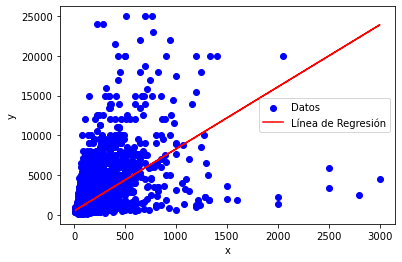

In [124]:
# Obtener las columnas x e y
x = df_clean['m_cuadrados'].values.reshape(-1, 1)
y = df_clean['precio'].values

# Crear un objeto de regresión lineal
regresion = LinearRegression()

# Ajustar el modelo de regresión
regresion.fit(x, y)

# Obtener los coeficientes de la regresión
coeficiente_intercepto = regresion.intercept_
coeficiente_pendiente = regresion.coef_[0]

# Realizar predicciones basadas en el modelo de regresión
y_pred = regresion.predict(x)

# Crear el gráfico
plt.scatter(x, y, color='blue', label='Datos')
plt.plot(x, y_pred, color='red', label='Línea de Regresión')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Mostrar el gráfico
plt.show()

### Matriz de correlación

In [125]:
# Calcular la matriz de correlación
matriz_correlacion = df_clean.corr()
matriz_correlacion

,precio,n_habitaciones,n_baños,m_cuadrados
precio,1.000000,0.277699,0.551120,0.564053
n_habitaciones,0.277699,1.000000,0.438473,0.404688
n_baños,0.551120,0.438473,1.000000,0.608223
m_cuadrados,0.564053,0.404688,0.608223,1.000000


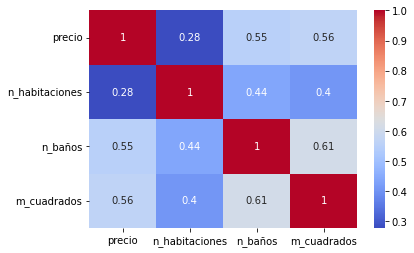

In [127]:
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm")
plt.show()

Se observa que la el número de metros cuadrados es la variable numérica más relacionada con el precio.

### Contraste de Hipótesis

La hipotesis nula es que en Vizcaya las casas son igual de caras que en Álava.

In [133]:
vizcaya_prices = df_clean[df_clean['zona']=='Vizcaya - Bizkaia']
alaba_prices = df_clean[df_clean['zona']=='Álava - Araba']

# Realizar la prueba t de Student para comparar las medias
stat, p_valor = ttest_ind(vizcaya_prices['precio'], alaba_prices['precio'], equal_var=False)

# Imprimir los resultados
print("Estadístico de prueba:", stat)
print("Valor p:", p_valor)

# Interpretar los resultados
alfa = 0.05
if p_valor < alfa:
    print("Se rechaza la hipótesis nula. Hay evidencia estadística de que las casas de Vizcaya son más caras que las de Álava.")
else:
    print("No se puede rechazar la hipótesis nula. No hay evidencia estadística suficiente para afirmar que las casas de Bilbao son más caras que las de Madrid.")

Estadístico de prueba: 4.011953113094736
Valor p: 0.00025201564818417963
Se rechaza la hipótesis nula. Hay evidencia estadística de que las casas de Vizcaya son más caras que las de Álava.
